# NetMHCPan Bruteforce Run
The NetMHCpan bruteforce is a nextflow epitopeprediction pipeline run that takes the inputs:
- Samplesheets (rows being patients)
- tsv per donor of the peptide list

### Parameters for Run

In [2]:
#use cleaned db: adjusted to our use case (778 donors out of all)
PATH_TO_TUEDB = '../../db_dump_311023_cleaned.tsv'
PATH_TO_ALL_TUEDB_ALLELES = 'all_tuedb_alleles.txt'
PATH_TO_NETMHCPAN_INPUT_FOLDER = 'epitopeprediction-input'
PATH_TO_NETMHCPAN_OUTPUT_FOLDER = 'epitopeprediction-output-30-11-2023'
PATH_TO_NETMHCPAN_DOWNLOAD = 'netMHCpan-4.1b.Linux.tar.gz'
PATH_TO_SAMPLESHEET = f'{PATH_TO_NETMHCPAN_INPUT_FOLDER}/samplesheet.csv'

In [3]:
#for analysis
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math

#for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

#for logging
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger('matplotlib.font_manager').disabled = True

### Load TuedDB Database for Patients (peptide list and HLA-Typing)
This is how the tuedb database dataframe looks like.

In [4]:
tuedb_df = pd.read_csv(PATH_TO_TUEDB, sep='\t', index_col=0)
tuedb_df = tuedb_df.sort_values(by=['donor_code'])
tuedb_df.head()

,peptide_sequence,donor_code,all_hla_alleles_donor,mhc_class,peptide_modifications,no_alleles
6646695,TTDLFGRDLSY,04-001,"['A0101', 'A2402', 'B0801', 'B1402', 'C0701', ...",I,NaN,6
6646540,AYLEAHETF,04-001,"['A0101', 'A2402', 'B0801', 'B1402', 'C0701', ...",I,NaN,6
6646539,NRFQIATV,04-001,"['A0101', 'A2402', 'B0801', 'B1402', 'C0701', ...",I,NaN,6
6646538,TAASRLVTL,04-001,"['A0101', 'A2402', 'B0801', 'B1402', 'C0701', ...",I,NaN,6
6646537,FTDVRAAVY,04-001,"['A0101', 'A2402', 'B0801', 'B1402', 'C0701', ...",I,NaN,6


### Prepare samplesheet for run

In [5]:
all_tuedb_alleles_list = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)
alleles = ';'.join(all_tuedb_alleles_list)

In [6]:
#collect first row for all donors
netmhcpan_samplesheet_df = tuedb_df.drop_duplicates(subset=['donor_code'], keep='first')
netmhcpan_samplesheet_df['all_hla_alleles_donor'] = netmhcpan_samplesheet_df['all_hla_alleles_donor'].apply(lambda l: ';'.join([x[0] + '*' + x[1:3] + ':' + x[3:] for x in eval(l)]))
#add column 'filename' that will hold the path to the input file for netmhcpan
netmhcpan_samplesheet_df['filename'] = [f'{PATH_TO_NETMHCPAN_INPUT_FOLDER}/{donor}.tsv' for donor in netmhcpan_samplesheet_df['donor_code']]
#set the an allele column to all alleles in TueDB for NetMHCpan to test against
netmhcpan_samplesheet_df['alleles'] = alleles
netmhcpan_samplesheet_df = netmhcpan_samplesheet_df.rename(columns={"donor_code": "sample"})
netmhcpan_samplesheet_df = netmhcpan_samplesheet_df.sort_values(by=['sample'])
netmhcpan_samplesheet_df = netmhcpan_samplesheet_df[['sample', 'alleles','mhc_class', 'filename']]

print('This is the samplesheet df, that is part of the input for netmhcpan: ')
netmhcpan_samplesheet_df.head()

## Save the DataFrame to a CSV file
#first_row_df.to_csv(PATH_TO_SAMPLESHEET, index=False)

This is the samplesheet df, that is part of the input for netmhcpan: 


,sample,alleles,mhc_class,filename
6646695,04-001,A*01:01;A*01:03;A*01:06;A*02:01;A*02:02;A*02:0...,I,epitopeprediction-input/04-001.tsv
6244751,1003,A*01:01;A*01:03;A*01:06;A*02:01;A*02:02;A*02:0...,I,epitopeprediction-input/1003.tsv
6223052,1008,A*01:01;A*01:03;A*01:06;A*02:01;A*02:02;A*02:0...,I,epitopeprediction-input/1008.tsv
6780716,1010,A*01:01;A*01:03;A*01:06;A*02:01;A*02:02;A*02:0...,I,epitopeprediction-input/1010.tsv
6815319,1012,A*01:01;A*01:03;A*01:06;A*02:01;A*02:02;A*02:0...,I,epitopeprediction-input/1012.tsv


### Prepare individual input for run

In [6]:
'''for donor_code in tuedb_df['donor_code'].unique():
    donor_data = tuedb_df[tuedb_df['donor_code'] == donor_code]
    
    # Create a DataFrame with 'id' and 'sequence' columns
    netmhcpan_input_donor_df = pd.DataFrame({
        'id': range(0, len(donor_data['peptide_sequence'].explode())),
        'sequence': donor_data['peptide_sequence'].explode().str.strip("[]").str.replace("'", "").str.split(',').explode().str.strip()
    })

    # Save the DataFrame to a TSV file
    #netmhcpan_input_donor_df.to_csv(f'{PATH_TO_NETMHCPAN_INPUT_FOLDER}/{donor_code}.tsv', sep='\t', index=False)'''

'for donor_code in tuedb_df[\'donor_code\'].unique():\n    donor_data = tuedb_df[tuedb_df[\'donor_code\'] == donor_code]\n    \n    # Create a DataFrame with \'id\' and \'sequence\' columns\n    netmhcpan_input_donor_df = pd.DataFrame({\n        \'id\': range(0, len(donor_data[\'peptide_sequence\'].explode())),\n        \'sequence\': donor_data[\'peptide_sequence\'].explode().str.strip("[]").str.replace("\'", "").str.split(\',\').explode().str.strip()\n    })\n\n    # Save the DataFrame to a TSV file\n    #netmhcpan_input_donor_df.to_csv(f\'{PATH_TO_NETMHCPAN_INPUT_FOLDER}/{donor_code}.tsv\', sep=\'\t\', index=False)'

### NetMHCPan Run
With the nextflow epitopeprediction pipeline, run this command:
TODO: Bitte als separates bash script providen

In [7]:
command = f'nextflow run nf-core/epitopeprediction -profile docker --outdir {PATH_TO_NETMHCPAN_OUTPUT_FOLDER} -r 2.2.1 --input {PATH_TO_NETMHCPAN_INPUT_FOLDER}/samplesheet.csv --tools netmhcpan-4.1 --netmhcpan_path {PATH_TO_NETMHCPAN_DOWNLOAD} --max_cpus 40 --max_memory 100.GB -resume'
print(command)

nextflow run nf-core/epitopeprediction -profile docker --outdir epitopeprediction-output-30-11-2023 -r 2.2.1 --input epitopeprediction-input/samplesheet.csv --tools netmhcpan-4.1 --netmhcpan_path netMHCpan-4.1b.Linux.tar.gz --max_cpus 40 --max_memory 100.GB -resume


Cite: NetMHCpan-4.1 and NetMHCIIpan-4.0: Improved predictions of MHC antigen presentation by concurrent motif deconvolution and integration of MS MHC eluted ligand data
Birkir Reynisson, Bruno Alvarez, Sinu Paul, Bjoern Peters and Morten Nielsen
Accepted for publication, NAR Webserver issue 2020

# NetMHCPan Bruteforce Evaluation
The input to this analysis is the NetMHCpan run output.
The samplesheet to this netmhcpan output is a samplesheet with the donors as samplesheet rows and their peptides with a collection of all alleles.

### Set parameters for Evaluation

In [7]:
PATH_TO_ALLELE_FREQUENCY = 'dkms_allele_freq_german.tsv'
PATH_TO_NETMHCPAN_OUTPUT_FOLDER = 'epitopeprediction-output-30-11-2023'
PATH_TO_ALL_TUEDB_ALLELES = 'all_tuedb_alleles.txt'

### Fetch Allele frequency

Germany DKMS - German donors mit n = 3,456,066
The german dataset is by far the largest allele frequency dataset, which is why I chose it.

Download the allele frequencies for the DKMS dataset on allelefrequencies.net
Select Settings: Locus: All loci, Population: Germany DKMS - German donors (n=3,456,066)
Search with Button: Use printer-friendly version.

Or use Downloadlink: http://allelefrequencies.net/hla6006a_scr.asp?hla_locus=&hla_locus_type=Classical&hla_allele1=&hla_allele2=&hla_selection=&hla_pop_selection=&hla_population=3767&hla_country=&hla_dataset=&hla_region=&hla_ethnic=&hla_study=&hla_sample_size=&hla_sample_size_pattern=equal&hla_sample_year=&hla_sample_year_pattern=equal&hla_level=&hla_level_pattern=equal&hla_show=&hla_order=order_1&standard=a


Cite: Gonzalez-Galarza FF, McCabe A, Santos EJMD, Jones J, Takeshita L, Ortega-Rivera ND, Cid-Pavon GMD, Ramsbottom K, Ghattaoraya G, Alfirevic A, Middleton D, Jones AR. Allele frequency net database (AFND) 2020 update: gold-standard data classification, open access genotype data and new query tools. Nucleic Acids Res. 2020 Jan 8;48(D1):D783-D788. doi: 10.1093/nar/gkz1029. PMID: 31722398; PMCID: PMC7145554.

In [8]:
#read out the allele frequencies
allele_freq_df = pd.read_csv(PATH_TO_ALLELE_FREQUENCY, sep='\t')
allele_freq_dict = dict(zip(allele_freq_df['Allele'], allele_freq_df['Allele Frequency']))

#load txt file with all alleles from tuedb
all_tuedb_alleles = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)

# Update the allele_freq_dict with missing alleles and set frequency to 0
for allele in all_tuedb_alleles:
    allele_freq_dict.setdefault(allele, 0)

sum_allele_freq_dict = sum(allele_freq_dict.values())
logging.info(f'The sum of all entries should be rounded 3 (100% per locus): {sum_allele_freq_dict}')
logging.info(f'The allele frequency dictionary looks like: {allele_freq_dict}')
logging.info(f'The tuedb alleles are: {all_tuedb_alleles}')

INFO:root:The sum of all entries should be rounded 3 (100% per locus): 2.9829
INFO:root:The allele frequency dictionary looks like: {'A*01:01': 0.1537, 'A*01:02': 0.0001, 'A*01:03': 0.0003, 'A*01:06': 0.0001, 'A*01:09': 0.0, 'A*01:13': 0.0, 'A*01:14': 0.0, 'A*01:15N': 0.0, 'A*01:17': 0.0, 'A*01:21': 0.0, 'A*01:23': 0.0, 'A*01:25': 0.0, 'A*01:26': 0.0, 'A*01:29': 0.0, 'A*01:30': 0.0, 'A*01:35': 0.0, 'A*01:38': 0.0, 'A*01:39': 0.0, 'A*01:40': 0.0, 'A*01:41': 0.0, 'A*01:42': 0.0, 'A*01:43': 0.0, 'A*01:44': 0.0, 'A*01:49': 0.0, 'A*01:51': 0.0, 'A*01:57N': 0.0, 'A*01:61': 0.0, 'A*01:65': 0.0, 'A*01:66': 0.0, 'A*01:67': 0.0, 'A*01:68': 0.0, 'A*01:69': 0.0, 'A*01:72': 0.0, 'A*01:76': 0.0, 'A*01:77': 0.0, 'A*01:83': 0.0, 'A*01:86': 0.0, 'A*01:88': 0.0, 'A*01:89': 0.0, 'A*01:95': 0.0, 'A*01:98': 0.0, 'A*01:99': 0.0, 'A*01:100': 0.0, 'A*01:101': 0.0, 'A*01:106': 0.0, 'A*01:113': 0.0, 'A*01:115': 0.0, 'A*01:117': 0.0, 'A*01:118': 0.0, 'A*01:123N': 0.0, 'A*01:124': 0.0, 'A*01:126': 0.0, 'A*01:128'

### Load filtered peptides for Gibbs Clustering
TODO soll in extra file weil es gibt kein gibbs clustering in netmhcpan appraoch

In [10]:
PATH_FILTERED_PEPTIDES_DICT = 'filtered_peptides_after_gibbs_clustering.txt'

with open(PATH_FILTERED_PEPTIDES_DICT, 'r') as f:
    filtered_peptides = f.readline()
    filtered_peptides = eval(filtered_peptides)

raw_alleles = [s.replace('*', '') for s in all_tuedb_alleles]
raw_alleles = [s.replace(':', '') for s in all_tuedb_alleles]

for a in raw_alleles:
    if a not in filtered_peptides.keys():
        filtered_peptides[a] = []

print(filtered_peptides)

{'A0101': ['APGSAAPAAGSAPAA', 'ALGQNPTNAEVLK', 'TEIRLRLHY', 'QGPGLGVYAY', 'PKPQDGKETKAAD', 'SDVSLTACKV', 'SQRYESLK', 'AHFGGADAARRY', 'ERLYPLRKYAVKA', 'ASVAWAVLK', 'LECFININY', 'AKKGGEKKK', 'IVDARPAMAATSF', 'ASFLRAQER', 'NTLPVSGNLID', 'LAKAGKNQGD', 'ADKASASAPAPASA', 'EKLRQNLNK', 'TKDGKKDKKEEDKK', 'MCPFLFLAV', 'KREPEDEGEDDD', 'SKNASKVANKGKSKS', 'TLDRLLALNS', 'VLPPPPPDT', 'YGGGGGGGY', 'KVRGTAKANVGAGKK', 'KSAQKAQKA', 'NFKTPRGPV', 'IIHEIAVLEL', 'ALDNTDLVFG', 'VSLTACKV', 'ASVPAGGAVAV', 'VRYHTKVR', 'SENSSQPAKK', 'ANFVMNPGDA', 'MVASVAFGH', 'AMSARAEAIK', 'NCRACAKSY', 'VLDINSIDN', 'GMGQKDSYVGD', 'LGPTAQWSVEDEEE', 'PRYHEVHY', 'GPGARARYQKSYR', 'AVLNRNRPEKN', 'RIHGVGFK', 'IVGRPRHQGVMV', 'SAPKKSKADGQ', 'ITELKAQLA', 'VTGKSKKRN', 'KKHKKLELDGSY', 'KIEARERK', 'VLLADGNN', 'RSHRRDQKW', 'GKGDPKKPRGK', 'VIILNHPGQISAG', 'SKKPAGGVDFDET', 'LFDNAMLR', 'SQSDTVFDY', 'VVVQPPTP', 'AGGKAGKDSGKAK', 'YESINYIF', 'APSGSSGGICEKSK', 'RVKENDQK', 'LSSQPTIPIVG', 'VAEGAEMV', 'YLSERYAEL', 'SHHKAKGK', 'SSHKTFRIKRFLA', 'VVRHQLLK

### NETMHCPAN BRUTEFORCE Evaluation
Majority Votum on 
(evaluate with rank column, rank<2 SB else NB)

### Settings

In [24]:
#SWITCH CONSIDER_WEAK_AND_STRONG_BINDER: 
# on: consider weak and strong binders (threshold at SB = 2 and WB = [0,0.025,0.05,0.075,0.01,0.1,0.2,0.5])
# off: consider only binder (threshold at 2)
# default for best result: True 
CONSIDER_WEAK_AND_STRONG_BINDER = False

# default for best result: 0
OPTIMAL_WEAK_BINDER_SCORE = 0

#SWITCH CONSIDER_ALLELE_FREQUENCY:
# on: consider allele frequency
# off: consider only binding affinity
# default for best result: True
CONSIDER_ALLELE_FREQUENCY = False

top_i = 2   


In [25]:
def evaluate_netmhcpan_df(netmhcpan_out_df: pd.DataFrame, all_tuedb_alleles: list) -> dict:
    """    
    Evaluate the NetMHCpan output DataFrame and return a majority vote with allele names as keys
    and the number of binders as values.

    Args:
        netmhcpan_out_df (pd.DataFrame): DataFrame containing NetMHCpan output data.
        all_tuedb_alleles (list): List of HLA alleles to consider.

    Returns:
        allele_binder_count_freq: A dictionary with allele names as keys and the number of binders as values.
    
    """
    allele_binder_count = {}
    all_tuedb_alleles = ['HLA-' + allele for allele in all_tuedb_alleles]
    allele_binder_count = {allele: 0 for allele in all_tuedb_alleles}

    rank_columns = netmhcpan_out_df.filter(regex='rank$', axis=1).columns
    netmhcpan_rank_df = netmhcpan_out_df[rank_columns]
    netmhcpan_rank_df['sequence'] = netmhcpan_out_df['sequence'].copy()

    for index,row in netmhcpan_rank_df.iterrows():
        for allele in all_tuedb_alleles:
            column_name = allele + ' rank'
            if column_name not in netmhcpan_rank_df.columns: 
                continue

            if CONSIDER_WEAK_AND_STRONG_BINDER:
                if netmhcpan_rank_df[column_name][index] < 0.5: #SB
                    allele_binder_count[allele] += 1
                elif netmhcpan_rank_df[column_name][index] < 2: #WB
                    allele_binder_count[allele] += OPTIMAL_WEAK_BINDER_SCORE
            if not CONSIDER_WEAK_AND_STRONG_BINDER:
                if netmhcpan_rank_df[column_name][index] <= 2:
                    allele_binder_count[allele] += 1

    allele_binder_count_freq = {k[4:]: v for k, v in allele_binder_count.items()}

    return allele_binder_count_freq

def get_best_from_majority_votum(allele_binder_count_freq: dict, top_i: int) -> list:
    """
    Selects the top HLA alleles based on the majority votum from NetMHCpan prediction.

    Args:
        allele_binder_count_freq (dict): A dictionary containing HLA allele names as keys and the number of binders as values.
        top_i (int): The number of top alleles to consider for each HLA locus.

    Returns:
        list: A list of selected HLA alleles based on the majority votum.
    """
    if CONSIDER_ALLELE_FREQUENCY:
        # Separate counts for HLA-A, HLA-B, and HLA-C _f consider allele frequency
        locus_a_counts_freq = {k: round(v*allele_freq_dict[k],2) for k, v in allele_binder_count_freq.items() if k.startswith('A')}
        locus_b_counts_freq = {k: round(v*allele_freq_dict[k],2) for k, v in allele_binder_count_freq.items() if k.startswith('B')}
        locus_c_counts_freq = {k: round(v*allele_freq_dict[k],2) for k, v in allele_binder_count_freq.items() if k.startswith('C')}
    else:
        # Separate counts for HLA-A, HLA-B, and HLA-C _f, allele frequency not considered
        locus_a_counts_freq = {k: v for k, v in allele_binder_count_freq.items() if k.startswith('A')}
        locus_b_counts_freq = {k: v for k, v in allele_binder_count_freq.items() if k.startswith('B')}
        locus_c_counts_freq = {k: v for k, v in allele_binder_count_freq.items() if k.startswith('C')}

    # Generate 3 dicts that have only the top_i highest values in them
    top_a_counts_freq = dict(sorted(locus_a_counts_freq.items(), key=lambda item: item[1], reverse=True)[:top_i])
    top_b_counts_freq = dict(sorted(locus_b_counts_freq.items(), key=lambda item: item[1], reverse=True)[:top_i])
    top_c_counts_freq = dict(sorted(locus_c_counts_freq.items(), key=lambda item: item[1], reverse=True)[:top_i])
    logging.debug(f'Top {top_i} counts for HLA-A with frequencies: {list(top_a_counts_freq.keys())}')
    logging.debug(f'Top {top_i} counts for HLA-B with frequencies: {list(top_b_counts_freq.keys())}')
    logging.debug(f'Top {top_i} counts for HLA-C with frequencies: {list(top_c_counts_freq.keys())}')

    prediction = list(top_a_counts_freq.keys()) + list(top_b_counts_freq.keys()) + list(top_c_counts_freq.keys())
    return prediction

def bruteforce_prediction(netmhcpan_out_df: pd.DataFrame, tp_alleles: list, all_tuedb_alleles: list, top_i: int) -> float:
    """
    Perform a brute-force prediction of HLA alleles' and evaluate against alleles in TueDB.

    Args:
        netmhcpan_out_df (pd.DataFrame): DataFrame containing NetMHCpan output data.
        tp_alleles (list): List of experimentally typed alleles for the donor.
        all_tuedb_alleles (list): List of all HLA alleles in the TueDB.
        top_i (int): The number of top alleles to consider for each HLA locus

    Returns:
        float: Percentage of correctly predicted alleles based on the majority votum.
    
    """
    #get majority votum for every allele for this donor from netmhcpan_df
    allele_binder_count_freq = evaluate_netmhcpan_df(netmhcpan_out_df, all_tuedb_alleles)

    #get prediction based on the majority votum, gives set of i*3 alleles (default 6 alleles)
    prediction = get_best_from_majority_votum(allele_binder_count_freq, top_i)
    logging.info(f'The experimentally typed alleles of the database are: {sorted(tp_alleles)}')
    logging.info(f'The prediction is (for every locus {top_i} most probable alleles): {sorted(prediction)}')

    #how good did the prediction score for the reality?
    match = 0
    for allele in tp_alleles:
        if allele in prediction:
            match += 1
    match_of_prediction = match / len(tp_alleles)

    logging.info(f'Prediction matching with {round(match_of_prediction*100,2)} %')
    return match_of_prediction


In [26]:
tuedb_samplesheet = pd.read_csv(PATH_TO_SAMPLESHEET, sep=',')
all_tuedb_alleles_list = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)

count_match_6 = []
count_match_56 = []
count_match_456 = []

for _,row in tuedb_samplesheet.iterrows():
    donor_code = row['sample']
    tp_alleles = eval(tuedb_df[tuedb_df['donor_code'] == donor_code]['all_hla_alleles_donor'].values[0])
    tp_alleles = [a[0]+'*'+a[1:3]+':'+a[3:] for a in tp_alleles]
    filename = f'{PATH_TO_NETMHCPAN_OUTPUT_FOLDER}/predictions/{donor_code}/{donor_code}_prediction_result.tsv'

    logging.info(f'Donor: {donor_code}')
    prediction_result = pd.read_csv(filename, sep='\t')

    match_of_prediction = bruteforce_prediction(prediction_result.copy(), tp_alleles, all_tuedb_alleles_list, top_i)
    
    if len(tp_alleles) == 6:
        count_match_6.append(match_of_prediction)
        count_match_56.append(match_of_prediction)
        count_match_456.append(match_of_prediction)
    if len(tp_alleles) == 5:
        count_match_56.append(match_of_prediction)
        count_match_456.append(match_of_prediction)
    if len(tp_alleles) == 4:
        count_match_456.append(match_of_prediction)
    logging.info(f'On average (looking at 4 and 5 and 6 allele donors) {np.mean(count_match_456)*100:.2f} % of alleles from {len(count_match_456)} donors with 4 or 5 or 6 alleles were predicted correctly.')

print(f'On average (only looking at 6 allele donors) {np.mean(count_match_6)*100:.2f} % of alleles from {len(count_match_6)} donors with 6 alleles were predicted correctly.')
print(f'On average (only looking at 5 and 6 allele donors) {np.mean(count_match_56)*100:.2f} % of alleles from {len(count_match_56)} donors with 5 or 6 alleles were predicted correctly.')
print(f'On average (only looking at 4 and 5 and 6 allele donors) {np.mean(count_match_456)*100:.2f} % of alleles from {len(count_match_456)} donors with 4 or 5 or 6 alleles were predicted correctly.')


INFO:root:Donor: 04-001
INFO:root:The experimentally typed alleles of the database are: ['A*01:01', 'A*24:02', 'B*08:01', 'B*14:02', 'C*07:01', 'C*08:02']
INFO:root:The prediction is (for every locus 2 most probable alleles): ['A*29:01', 'A*30:04', 'B*08:02', 'B*14:01', 'C*07:01', 'C*07:02']
INFO:root:Prediction matching with 16.67 %
INFO:root:On average (looking at 4 and 5 and 6 allele donors) 16.67 % of alleles from 1 donors with 4 or 5 or 6 alleles were predicted correctly.
INFO:root:Donor: 1003
INFO:root:The experimentally typed alleles of the database are: ['A*01:01', 'A*02:01', 'B*51:01', 'B*57:01', 'C*04:01', 'C*06:02']
INFO:root:The prediction is (for every locus 2 most probable alleles): ['A*32:01', 'A*32:03', 'B*08:02', 'B*52:01', 'C*02:03', 'C*04:01']
INFO:root:Prediction matching with 16.67 %
INFO:root:On average (looking at 4 and 5 and 6 allele donors) 16.67 % of alleles from 2 donors with 4 or 5 or 6 alleles were predicted correctly.
INFO:root:Donor: 1008
INFO:root:The ex

KeyboardInterrupt: 

# NetMHCpan Bruteforce Baseline with 6 most probable alleles in german population
Answers Question: Does approach only work well because there are common alleles in the allele set of the patients?
--> 29%
### Get most probable German Alleles

In [17]:
allele_freq_dict_a = {}
allele_freq_dict_b = {}
allele_freq_dict_c = {}

for key, value in allele_freq_dict.items():
    if key.startswith('A'):
        allele_freq_dict_a[key] = value
    elif key.startswith('B'):
        allele_freq_dict_b[key] = value
    elif key.startswith('C'):
        allele_freq_dict_c[key] = value

# Get top 2 items for each dictionary
top_two_a = sorted(allele_freq_dict_a.items(), key=lambda x: x[1], reverse=True)[:2]
top_two_b = sorted(allele_freq_dict_b.items(), key=lambda x: x[1], reverse=True)[:2]
top_two_c = sorted(allele_freq_dict_c.items(), key=lambda x: x[1], reverse=True)[:2]

keys_a = [item[0] for item in top_two_a]
keys_b = [item[0] for item in top_two_b]
keys_c = [item[0] for item in top_two_c]

# Combining all keys into one list
most_probable_german_alleles = keys_a + keys_b + keys_c
print(f'The most probable alleles in Germany are: {most_probable_german_alleles}')

The most probable alleles in Germany are: ['A*02:01', 'A*01:01', 'B*07:02', 'B*08:01', 'C*07:01', 'C*07:02']


In [18]:
def bruteforce_most_probable_alleles(tp_alleles: list, most_probable_german_alleles: list) -> float:
    """
    Perform a brute-force prediction with the 6 most common alleles in german population

    Args:
        tp_alleles (list): List of experimentally typed alleles for the donor.
        most_probable_german_alleles (list): List of most probable German HLA alleles.

    Returns:
        float: Percentage of correctly predicted alleles based on the experimentally typed alleles.
    """

    prediction = most_probable_german_alleles
    match = 0
    for allele in tp_alleles:
        if allele in prediction:
            match += 1
    match_of_prediction = match / len(tp_alleles)
    logging.info(f'Prediction matching with {round(match_of_prediction*100,2)} %')

    return match_of_prediction

In [19]:
tuedb_samplesheet = pd.read_csv(PATH_TO_SAMPLESHEET, sep=',')
all_tuedb_alleles_list = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)

count_match_6 = []
count_match_56 = []
count_match_456 = []

for index, row in tuedb_samplesheet.iterrows():
    donor_code = row['sample']
    tp_alleles = eval(tuedb_df[tuedb_df['donor_code'] == donor_code]['all_hla_alleles_donor'].values[0])
    tp_alleles = [f'{a[0]}*{a[1:3]}:{a[3:]}' for a in tp_alleles]
    
    logging.debug(f'Donor: {donor_code}')
    match_of_prediction = bruteforce_most_probable_alleles(tp_alleles, most_probable_german_alleles)
    
    if len(tp_alleles) == 6:
        count_match_6.append(match_of_prediction)
        count_match_56.append(match_of_prediction)
        count_match_456.append(match_of_prediction)
    if len(tp_alleles) == 5:
        count_match_56.append(match_of_prediction)
        count_match_456.append(match_of_prediction)
    if len(tp_alleles) == 4:
        count_match_456.append(match_of_prediction)
    logging.debug(f'On average (looking at 4 and 5 and 6 allele donors) {np.mean(count_match_456)*100:.2f} % of alleles from {len(count_match_456)} donors with 4 or 5 or 6 alleles were predicted correctly.')

print(f'On average (only looking at 6 allele donors) {np.mean(count_match_6)*100:.2f} % of alleles from {len(count_match_6)} donors with 6 alleles were predicted correctly.')
print(f'On average (only looking at 5 and 6 allele donors) {np.mean(count_match_56)*100:.2f} % of alleles from {len(count_match_56)} donors with 5 or 6 alleles were predicted correctly.')
print(f'On average (only looking at 4 and 5 and 6 allele donors) {np.mean(count_match_456)*100:.2f} % of alleles from {len(count_match_456)} donors with 4 or 5 or 6 alleles were predicted correctly.')


INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 33.33 %
INFO:root:Prediction matching with 66.67 %
INFO:root:Prediction matching with 16.67 %
INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 100.0 %
INFO:root:Prediction matching with 16.67 %
INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 60.0 %
INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 33.33 %
INFO:root:Prediction matching with 100.0 %
INFO:root:Prediction matching with 16.67 %
INFO:root:Prediction matching with 16.67 %
INFO:root:Prediction matching with 16.67 %
INFO:root:Prediction matching with 33.33 %
INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 60.0 %
INFO:root:Prediction matching with 0.0 %
INFO:root:Prediction matching with 50.0 %
INFO:root:Prediction matching with 16.67 %
INFO:root:Prediction matching with 66.67 %
INFO:root:Prediction m

On average (only looking at 6 allele donors) 27.25 % of alleles from 551 donors with 6 alleles were predicted correctly.
On average (only looking at 5 and 6 allele donors) 28.28 % of alleles from 715 donors with 5 or 6 alleles were predicted correctly.
On average (only looking at 4 and 5 and 6 allele donors) 28.64 % of alleles from 753 donors with 4 or 5 or 6 alleles were predicted correctly.


# NetMHCPan Bruteforce Run for in-house database
### Parameters

In [30]:
PATH_TO_NETMHCPAN_OUTPUT_FOLDER_IN_HOUSE = 'epitopeprediction-output-in-house'
PATH_TO_NETMHCPAN_INPUT_CSV_FOLDER_IN_HOUSE = 'epitopeprediction-input/samplesheet-in-house.csv'
PATH_TO_NETMHCPAN_DOWNLOAD = 'netMHCpan-4.1b.Linux.tar.gz'

In [31]:
command = f'nextflow run nf-core/epitopeprediction -profile docker --outdir {PATH_TO_NETMHCPAN_OUTPUT_FOLDER_IN_HOUSE} -r 2.2.1 --input {PATH_TO_NETMHCPAN_INPUT_CSV_FOLDER_IN_HOUSE} --tools netmhcpan-4.1 --netmhcpan_path {PATH_TO_NETMHCPAN_DOWNLOAD} --max_cpus 40 --max_memory 100.GB'
print(command)

nextflow run nf-core/epitopeprediction -profile docker --outdir epitopeprediction-output-in-house -r 2.2.1 --input epitopeprediction-input/samplesheet-in-house.csv --tools netmhcpan-4.1 --netmhcpan_path netMHCpan-4.1b.Linux.tar.gz --max_cpus 40 --max_memory 100.GB


# NETMHCpan Bruteforce Evaluation on in-house database

### Parameters

In [ ]:
PATH_TO_IN_HOUSE_DB = 'gosh_with_typing.tsv'
PATH_TO_NETMHCPAN_OUTPUT_FOLDER_IN_HOUSE = 'epitopeprediction-output-in-house/predictions/gosh/gosh_prediction_result.tsv'

#SWITCH CONSIDER_WEAK_AND_STRONG_BINDER: 
# on: consider weak and strong binders (threshold at 2 and 0.5)
# off: consider only binder (threshold at 2)
CONSIDER_WEAK_AND_STRONG_BINDER = False

#SWITCH CONSIDER_ALLELE_FREQUENCY:
# on: consider allele frequency
# off: consider only binding affinity
CONSIDER_ALLELE_FREQUENCY = True

#switch CONSIDER_ALLELE_FREQUENCY_FOR_IN_HOUSE -> makes no difference here
# on: consider allele frequency
# off: consider only binding affinity
CONSIDER_ALLELE_FREQUENCY_FOR_IN_HOUSE = True

OPTIMAL_WEAK_BINDER_SCORE = 0

top_i = 1

In [ ]:
def analysis_in_house_db(netmhcpan_out_df: pd.DataFrame, tp_alleles: list, all_tuedb_alleles: list) -> str:
    
    allele_binder_count_freq = evaluate_netmhcpan_df(netmhcpan_out_df, all_tuedb_alleles)

    #get allele prediction based on the majority votum, gives set of i*3 alleles (default 6 alleles)
    prediction = get_best_from_majority_votum(allele_binder_count_freq, top_i)
    prediction_a = prediction[0]
    prediction_b = prediction[1]
    prediction_c = prediction[2]

    if tp_alleles.startswith('A'):
        predicted_allele = prediction_a
    elif tp_alleles.startswith('B'):
        predicted_allele = prediction_b
    elif tp_alleles.startswith('C'):
        predicted_allele = prediction_c
    
    predicted_allele = predicted_allele.replace('*','')
    predicted_allele = predicted_allele.replace(':','')

    logging.info(f'The prediction (with frequency taken into account) is: {predicted_allele}')

    return predicted_allele

In [ ]:
samplesheet = pd.read_csv(PATH_TO_IN_HOUSE_DB, sep='\t')

match = 0
no_match = 0
donor_count = 0

filename = PATH_TO_NETMHCPAN_OUTPUT_FOLDER_IN_HOUSE

for index, row in samplesheet.iterrows():
    donor_count += 1
    donor_code = row['id']
    tp_alleles = str(row['gosh_typing'])
    tp_alleles = tp_alleles.replace('*','')
    tp_alleles = tp_alleles.replace(':','')
    logging.info(f'Sample ID: {donor_code}')
    prediction_result = pd.read_csv(filename, sep='\t')
    predicted_allele = analysis_in_house_db(prediction_result.copy(), tp_alleles, all_tuedb_alleles)
    
    if predicted_allele.startswith(tp_alleles) or (f'{predicted_allele[0]}0{predicted_allele[1:]}').startswith(tp_alleles):
        match += 1
    else:
        no_match += 1

    logging.info(f'match_f: {match}, no_match_f: {no_match}')

print(f'There are {donor_count} donors in all.')
print(f'There are {match} matches and {no_match} no matches (with frequency taken into account).')

# NetMHCPan Bruteforce Evaluation for 2-digit Alleles Approach
The NetMHCpan Analysis stays the same but we evaluate for 2-digit alleles and not 4-digit alleles as previously (accuracy improves because the deviation of the prediction from the true positive alleles can be greater if it  should be counted as match)

### Convert 4-digit typed allele frequency dictionary into 2-digit typed alleles

In [32]:
PATH_TO_ALLELE_FREQUENCY = 'dkms_allele_freq_german.tsv'
PATH_TO_ALL_TUEDB_ALLELES = 'all_tuedb_alleles.txt'
PATH_TO_ALL_TUEDB_ALLELES_2DIGIT = 'all_tuedb_alleles_2digit.txt'
PATH_TO_NETMHCPAN_OUTPUT_FOLDER = 'epitopeprediction-output-30-11-2023'

In [33]:
allele_freq_df = pd.read_csv(PATH_TO_ALLELE_FREQUENCY, sep='\t')

allele_freq_dict_4digits = dict(zip(allele_freq_df['Allele'], allele_freq_df['Allele Frequency']))
all_tuedb_alleles = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)
all_tuedb_alleles_2digits = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES_2DIGIT, dtype=str)

# Update the allele_freq_dict with missing alleles and set frequency to 0
for allele in all_tuedb_alleles:
    allele_freq_dict_4digits.setdefault(allele, 0)

#take the 2 digit alleles and add the frequencies of the fine alleles
allele_freq_dict = {}
for two_digit_allele in all_tuedb_alleles_2digits:
    allele_freq_dict[two_digit_allele] = 0
    for fine_allele in allele_freq_dict_4digits.keys():
        if fine_allele.startswith(two_digit_allele):
            allele_freq_dict[two_digit_allele] += allele_freq_dict_4digits[fine_allele]

#round of all values to 4 digits after comma
allele_freq_dict = {k: round(v,4) for k, v in allele_freq_dict.items()}
logging.info(f'The sum of all entries should be rounded 3 (100% per locus): {sum_allele_freq_dict}')
print(f'The allele frequency dictionary for 2 digits looks like: {allele_freq_dict}')
print(f'The allele frequency dictionary for 4 digits looks like: {allele_freq_dict_4digits}')


INFO:root:The sum of all entries should be rounded 3 (100% per locus): 2.9829


The allele frequency dictionary for 2 digits looks like: {'A*01': 0.1542, 'A*02': 0.2963, 'A*03': 0.1531, 'A*11': 0.0528, 'A*23': 0.0212, 'A*24': 0.0929, 'A*25': 0.025, 'A*26': 0.0327, 'A*29': 0.0255, 'A*30': 0.0208, 'A*31': 0.0235, 'A*32': 0.036, 'A*33': 0.011, 'A*34': 0.0005, 'A*66': 0.0044, 'A*68': 0.0428, 'A*69': 0.0008, 'A*80': 0.0002, 'B*07': 0.1319, 'B*08': 0.1022, 'B*13': 0.0346, 'B*14': 0.0238, 'B*15': 0.0835, 'B*18': 0.0486, 'B*27': 0.0446, 'B*35': 0.0938, 'B*37': 0.0137, 'B*38': 0.0217, 'B*39': 0.0195, 'B*40': 0.0683, 'B*41': 0.0096, 'B*42': 0.0003, 'B*44': 0.1263, 'B*45': 0.0044, 'B*46': 0.0002, 'B*47': 0.0032, 'B*49': 0.0129, 'B*50': 0.0108, 'B*51': 0.0591, 'B*52': 0.0088, 'B*53': 0.0032, 'B*55': 0.0153, 'B*56': 0.0091, 'B*57': 0.0359, 'B*58': 0.0079, 'C*01': 0.0351, 'C*02': 0.0565, 'C*03': 0.1424, 'C*04': 0.115, 'C*05': 0.0702, 'C*06': 0.1009, 'C*07': 0.3075, 'C*08': 0.0236, 'C*12': 0.0659, 'C*14': 0.0137, 'C*15': 0.0269, 'C*16': 0.0274, 'C*17': 0.0089}
The allele frequen

### Settings

In [34]:
#SWITCH CONSIDER_WEAK_AND_STRONG_BINDER: 
# on: consider weak and strong binders (threshold at 2 and 0.5)
# off: consider only binder (threshold at 2)
CONSIDER_WEAK_AND_STRONG_BINDER = True
OPTIMAL_WEAK_BINDER_SCORE = 0

#SWITCH CONSIDER_ALLELE_FREQUENCY:
# on: consider allele frequency
# off: consider only binding affinity
CONSIDER_ALLELE_FREQUENCY = True

TEST_IN_HOUSE = False

top_i = 2

In [38]:
def make_dict_2_digit_typed(dict: dict) -> dict:
    """
    Convert entries in a dictionary by grouping them based on the first four characters of the keys.

    Args:
        input_dict (dict): The input dictionary with keys to be converted.

    Returns:
        dict: A new dictionary with 2-digit alleles as keys.
    """

    new_dict = {}
    for key in dict:
        if key[:4] in new_dict:
            new_dict[key[:4]] += dict[key]
        else:
            new_dict[key[:4]] = dict[key]
    return new_dict

def bruteforce_prediction_2_digit(netmhcpan_out_df: pd.DataFrame, tp_alleles: list, all_tuedb_alleles: list, top_i: int) -> float:
    """
    Perform a brute-force prediction of HLA alleles looking only at 2-digit alleles.

    Args:
        netmhcpan_out_df (pd.DataFrame): DataFrame containing NetMHCpan output data.
        tp_alleles (list): List of experimentally typed alleles for the donor.
        all_tuedb_alleles (list): List of all HLA alleles in the TueDB.
        top_i (int): The number of top alleles to consider for each HLA locus in the majority votum.

    Returns:
        float: Percentage of correctly predicted alleles based on the experimentally typed alleles.
    """
    
    netmhcpan_out_df.head()
    #get majority votum for every allele for this donor from netmhcpan_df
    allele_binder_count_freq = evaluate_netmhcpan_df(netmhcpan_out_df, all_tuedb_alleles)
    
    allele_binder_count_freq = make_dict_2_digit_typed(allele_binder_count_freq)

    #get prediction based on the majority votum, gives set of i*3 alleles (default 6 alleles)
    prediction = get_best_from_majority_votum(allele_binder_count_freq, top_i)
    
    logging.info(f'The experimentally typed alleles of the database are: {sorted(tp_alleles)}')
    logging.info(f'The prediction is (for every locus {top_i} most probable alleles): {sorted(prediction)}')

    #make true positive alleles rough typed
    tp_alleles = [a[:4] for a in tp_alleles]
    match = 0
    for allele in tp_alleles:
        if allele in prediction:
            match += 1
    match_of_prediction = match / len(tp_alleles)

    logging.debug(f'Prediction matching with {round(match_of_prediction*100,2)} %')
    return match_of_prediction
    

In [40]:
tuedb_samplesheet = pd.read_csv(PATH_TO_SAMPLESHEET, sep=',')
all_tuedb_alleles_list = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)

count_match_6 = []
count_match_56 = []
count_match_456 = []

for index,row in tuedb_samplesheet.iterrows():
    donor_code = row['sample']
    tp_alleles = eval(tuedb_df[tuedb_df['donor_code'] == donor_code]['all_hla_alleles_donor'].values[0])
    tp_alleles = [f'{a[0]}*{a[1:3]}:{a[3:]}' for a in tp_alleles]
    filename = f'{PATH_TO_NETMHCPAN_OUTPUT_FOLDER}/predictions/{donor_code}/{donor_code}_prediction_result.tsv'

    logging.debug(f'Donor: {donor_code}')
    prediction_result = pd.read_csv(filename, sep='\t')

    match_of_prediction = bruteforce_prediction_2_digit(prediction_result.copy(), tp_alleles, all_tuedb_alleles_list, top_i)
    
    if len(tp_alleles) == 6:
        count_match_6.append(match_of_prediction)
        count_match_56.append(match_of_prediction)
        count_match_456.append(match_of_prediction)
    if len(tp_alleles) == 5:
        count_match_56.append(match_of_prediction)
        count_match_456.append(match_of_prediction)
    if len(tp_alleles) == 4:
        count_match_456.append(match_of_prediction)
    #logging.info(f'On average (looking at 6 allele donors) {round(np.sum(count_match_6)/len(count_match_6),2)*100} % of alleles from {len(count_match_6)} donors with 6 alleles were predicted correctly.')
    #logging.info(f'On average (looking at 5 and 6 allele donors) {round(np.sum(count_match_56)/len(count_match_56),2)*100} % of alleles from {len(count_match_56)} donors with 5 or 6 alleles were predicted correctly.')
    logging.info(f'On average (looking at 4 and 5 and 6 allele donors) {np.mean(count_match_456)*100:.2f} % of alleles from {len(count_match_456)} donors with 4 or 5 or 6 alleles were predicted correctly.')

print(f'On average (only looking at 6 allele donors) {np.mean(count_match_6)*100:.2f} % of alleles from {len(count_match_6)} donors with 6 alleles were predicted correctly.')
print(f'On average (only looking at 5 and 6 allele donors) {np.mean(count_match_56)*100:.2f} % of alleles from {len(count_match_56)} donors with 5 or 6 alleles were predicted correctly.')
print(f'On average (only looking at 4 and 5 and 6 allele donors) {np.mean(count_match_456)*100:.2f} % of alleles from {len(count_match_456)} donors with 4 or 5 or 6 alleles were predicted correctly.')


INFO:root:The experimentally typed alleles of the database are: ['A*01:01', 'A*24:02', 'B*08:01', 'B*14:02', 'C*07:01', 'C*08:02']
INFO:root:The prediction is (for every locus 2 most probable alleles): ['A*01', 'A*24', 'B*08', 'B*15', 'C*03', 'C*07']
INFO:root:On average (looking at 4 and 5 and 6 allele donors) 66.67 % of alleles from 1 donors with 4 or 5 or 6 alleles were predicted correctly.
INFO:root:The experimentally typed alleles of the database are: ['A*01:01', 'A*02:01', 'B*51:01', 'B*57:01', 'C*04:01', 'C*06:02']
INFO:root:The prediction is (for every locus 2 most probable alleles): ['A*01', 'A*02', 'B*15', 'B*35', 'C*03', 'C*07']
INFO:root:On average (looking at 4 and 5 and 6 allele donors) 50.00 % of alleles from 2 donors with 4 or 5 or 6 alleles were predicted correctly.
INFO:root:The experimentally typed alleles of the database are: ['A*01:01', 'A*02:01', 'B*08:01', 'B*40:01', 'C*03:04', 'C*07:01']
INFO:root:The prediction is (for every locus 2 most probable alleles): ['A*

On average (only looking at 6 allele donors) 50.00 % of alleles from 551 donors with 6 alleles were predicted correctly.
On average (only looking at 5 and 6 allele donors) 51.93 % of alleles from 715 donors with 5 or 6 alleles were predicted correctly.
On average (only looking at 4 and 5 and 6 allele donors) 52.36 % of alleles from 753 donors with 4 or 5 or 6 alleles were predicted correctly.


# Plotting

### Generate dictionary with lengths of peptide sequences before and after gibbs clustering

In [27]:
directory_path_before = 'gibbs-cluster-input-all-and-without-X'
directory_path_after = 'gibbs-cluster-output-all-wo-X-dupl'

def count_lines(file_path: str) -> int:
    """
    Count the number of lines in a file.

    Args:
        file_path (str): The path to the file.
    
    Returns:
        int: The number of lines in the file.

    """
    with open(file_path) as file:
        unique_lines = set()
        for line in file:
            unique_lines.add(line)
    return len(unique_lines)

def make_dictionary(directory_path: str) -> dict:
    """
    Create a dictionary with the number of peptides per allele in file.

    Args:
        directory_path (str): The path to the directory with the files.
    
    Returns:
        dict: A dictionary with the number of peptides per allele in file.

    """
    txt_files = [file for file in os.listdir(directory_path) if file.endswith('.txt')]
    result_dict = {}
    for txt_file in txt_files:
        file_path = os.path.join(directory_path, txt_file)
        line_count = count_lines(file_path)
        result_dict[txt_file[:-4]] = line_count
    return result_dict

before = make_dictionary(directory_path_before)
after = make_dictionary(directory_path_after)
print(f'The amount of peptides per allele before the clustering are: {before}')
print(f'The amount of peptides per allele after the clustering are: {after}')

The amount of peptides per allele before the clustering are: {'A0101': 13631, 'A0103': 7, 'A0201': 32982, 'A0202': 6393, 'A0203': 5895, 'A0204': 3750, 'A0205': 6028, 'A0206': 6603, 'A0207': 4932, 'A0208': 1, 'A0209': 1, 'A0211': 3473, 'A0212': 308, 'A0214': 9, 'A0216': 181, 'A0217': 177, 'A0219': 234, 'A0220': 983, 'A0250': 88, 'A0252': 2029, 'A0301': 23968, 'A0302': 1320, 'A0319': 14, 'A1101': 16408, 'A1102': 3782, 'A2301': 5139, 'A2401': 1, 'A2402': 14529, 'A2403': 287, 'A2406': 407, 'A2407': 2268, 'A2413': 250, 'A2501': 3235, 'A2601': 3911, 'A2602': 169, 'A2603': 63, 'A2608': 633, 'A2901': 144, 'A2902': 8930, 'A3001': 4478, 'A3002': 4801, 'A3003': 20, 'A3004': 100, 'A3101': 5974, 'A3201': 4453, 'A3207': 78, 'A3215': 59, 'A3301': 4366, 'A3303': 3916, 'A3401': 2992, 'A3402': 5846, 'A3601': 3561, 'A6601': 2745, 'A6602': 31, 'A6801': 13977, 'A6802': 5669, 'A6823': 76, 'A6901': 1001, 'A7401': 3495, 'A8001': 120, 'B0701': 60, 'B0702': 22931, 'B0704': 2435, 'B0801': 14206, 'B0801L': 952, '

### Plot that shows amount of peptides filtered out
TODO move that to extra gibbs cluster file

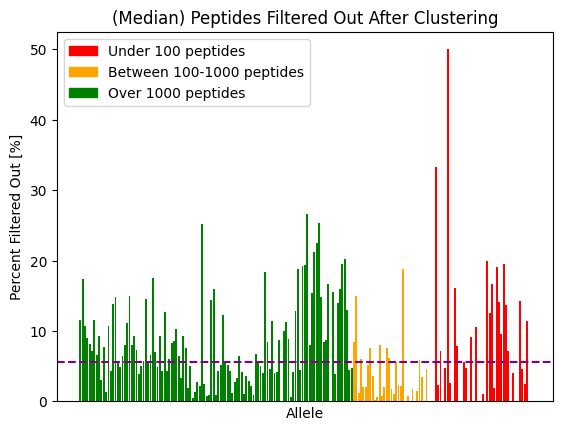

In [28]:
alleles = list(before.keys())
percent_filtered_out = {k: (before[k] - after[k]) * 100 / before[k] for k in before.keys()}

median_percent = np.median(list(percent_filtered_out.values()))
mean_percent = np.mean(list(percent_filtered_out.values()))

# Define color categories for peptides count
colors = []
for allele in percent_filtered_out.keys():
    if before[allele] < 100:
        colors.append('red')
    elif before[allele] < 1000:
        colors.append('orange')
    else:
        colors.append('green')

# Create a custom legend for sorted colors
legend_labels = ['Under 100 peptides', 'Between 100-1000 peptides', 'Over 1000 peptides']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in ['red', 'orange', 'green']]
plt.legend(legend_handles, legend_labels)

# Sort alleles, colors, and values based on colors
sorted_data = sorted(zip(percent_filtered_out.keys(), colors, percent_filtered_out.values()), key=lambda x: x[1])
alleles, colors, sorted_percent_filtered_out = zip(*sorted_data)

# Plot bars with sorted colors
for allele, color, value in zip(alleles, colors, sorted_percent_filtered_out):
    plt.bar(allele, value, color=color)

# Add a horizontal line for the median
plt.axhline(y=median_percent, color='purple', linestyle='--', label=f'Median: {median_percent:.1f}%')
plt.xlabel('Allele')
plt.ylabel('Percent Filtered Out [%]')
plt.title('(Median) Peptides Filtered Out After Clustering')
plt.xticks([])
plt.show()


### Box plot of percent of peptide filtered out

Text(0, 0.5, 'Percent Filtered Out [%]')

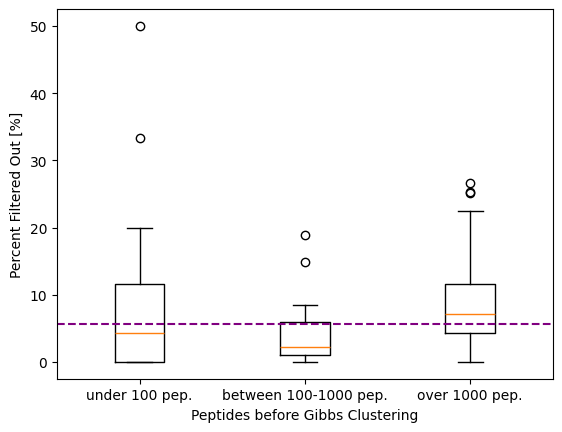

In [29]:
percent_filtered_out = {k: (before[k] - after[k]) * 100 / before[k] for k in before.keys()}
under_100 = []
between_100_1000 = []
over_1000 = []

for k in percent_filtered_out.keys():
    if before[k] < 100:
        under_100.append(percent_filtered_out[k])
    elif before[k] < 1000:
        between_100_1000.append(percent_filtered_out[k])
    else:
        over_1000.append(percent_filtered_out[k])

plt.boxplot([under_100, between_100_1000, over_1000])
plt.axhline(y=median_percent, color='purple', linestyle='--', label=f'Median: {mean_percent:.1f}%')
plt.xticks([1, 2, 3], ['under 100 pep.', 'between 100-1000 pep.', 'over 1000 pep.'])
plt.xlabel('Peptides before Gibbs Clustering')
plt.ylabel('Percent Filtered Out [%]')


### Plot that shows 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Optimising accuracy with weak binder score')

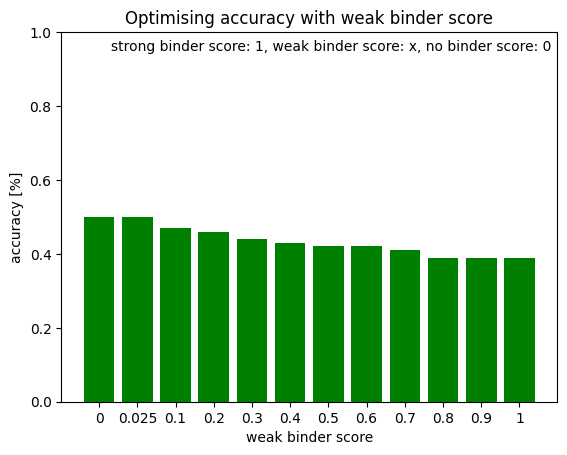

In [30]:
# plot strong binder/weak binder score optimisation with accuracy in percentage 
scores = ['0','0.025','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
# Accuracies from rum throughs with different weak binder scores
accuracies = [0.50,0.50,0.47,0.46,0.44,0.43,0.42,0.42,0.41,0.39,0.39,0.39]
color = ['green']*len(accuracies)
plt.bar(scores,accuracies,color=color)
plt.ylim(0,1)
plt.xlabel('weak binder score')
plt.ylabel('accuracy [%]')
plt.text(0.3,0.95,'strong binder score: 1, weak binder score: x, no binder score: 0')
plt.title('Optimising accuracy with weak binder score')